In [1]:
import numpy                as np
import matplotlib.pyplot    as plt
from astropy import units   as units
import sys
from matplotlib             import rcParams, rc
from scipy.interpolate  import interp1d


# Change the matplotlib default parameters
rcParams.update({'font.size':   8})
rcParams.update({'figure.dpi': 120})

sys.path.append('/lhome/silkem/ChemTorch/ChemTorch/')
from src.solve_n_save       import solve_dg
from src.input              import density
# from src.datagen            import genSamples, next_input, get_dt, get_temp
import src.rates            as rates

rate = 16

outloc = '/lhome/silkem/ChemTorch/ChemTorch/out/'
samploc = '/lhome/silkem/ChemTorch/ChemTorch/sampling/'
dataloc = '/lhome/silkem/ChemTorch/PhantomSampling/'

In [2]:
outloc = '/lhome/silkem/ChemTorch/ChemTorch/out/'
samploc = '/lhome/silkem/ChemTorch/ChemTorch/sampling/'
dataloc = '/lhome/silkem/ChemTorch/PhantomSampling/'

## Ranges from PHANTOM models
ρ_min = min(np.load(samploc+'drho_range.npy'))
ρ_max = max(np.load(samploc+'drho_range.npy'))
T_min = min(np.load(samploc+'dT_range.npy'))
T_max = max(np.load(samploc+'dT_range.npy'))
δ_min = 1.e-6
δ_max = 1
Av_min = -1
Av_max = -np.log10(δ_min)
dt_min = min(np.load(samploc+'dtime_range.npy'))
dt_max = max(np.load(samploc+'dtime_range.npy'))

nstep = 512

### !!! HIER VERONDERSTELLEN WE ONGECORRELEERDE PARAMETERS


def fdens(x):
	rho_func = np.load(samploc+'drho.npy') 
	return rho_func

def ftemp(x):
	T_func = np.load(samploc+'dT.npy') 
	return T_func

def fdelta(x):
	return np.ones_like(x)

def fAv(x):
	return np.ones_like(x)

# def fdt(x):
# 	return x**3./(-1.+np.exp(-x+3.8001))

def fdt(x):
	time_func = np.load(samploc+'dtime.npy') 
	return time_func

## cummulative sum 
## generate random numbers between [0,1)
## Define a function to return N samples
def genSamples(xmin, xmax, nstep, N, f):
	if f == fdelta:
		xbin = np.logspace(np.log10(xmin), np.log10(xmax), nstep)
	else:
		xbin = np.linspace(xmin, xmax, nstep)
	# print(xmin,xmax)
	ycum = np.cumsum(f(xbin))
	# plt.plot(ycum)
	if f == fdelta:
		xbin = np.logspace(np.log10(xmin), np.log10(xmax), len(ycum))
	else:
		xbin = np.linspace(xmin, xmax, len(ycum))
	u = np.random.uniform(ycum.min(), ycum.max(), int(N))
	## take the inverse of cumm. function
	func_interp = interp1d(ycum, xbin)
	samples = func_interp(u)
	return samples
	

def calc_next(f, param_i, min, max, nstep):
	N = 1
	ε = genSamples(min, max, nstep, N, f)
	# print(ε)
	param_next = (ε + 1)*param_i
	return param_next[0]

def next_input_idv(ρ, T, δ, Av):
	ρ_next  = calc_next(fdens , ρ , ρ_min , ρ_max , nstep)
	T_next  = calc_next(ftemp , T , T_min , T_max , nstep)
	δ_next  = calc_next(fdelta, δ , δ_min , δ_max , nstep)
	Av_next = calc_next(fAv   , Av, Av_min, Av_max, nstep)
	return ρ_next, T_next, δ_next, Av_next

def next_input(input):
	ρ = input[0]
	T = input[1]
	ρ_next  = calc_next(fdens , ρ , ρ_min , ρ_max , nstep)
	T_next  = calc_next(ftemp , T , T_min , T_max , nstep)
	δ_next  = genSamples(δ_min , δ_max , nstep, 1, fdelta)[0]
	Av_next = genSamples(Av_min, Av_max, nstep, 1, fAv)[0]
	return [ρ_next, T_next, δ_next, Av_next]

def get_dt():
	return genSamples(dt_min, dt_max, nstep, 1, fdt)[0] 


def get_temp(T, eps, r):
    R_star = 1.0e14            ## cm
    temp = T*(r/R_star)**-eps
    return temp


In [3]:

r = np.array(np.logspace(14,18, 100))
dens = density(1e-8, 5.,r )
temp = get_temp(3000,0.4, r) 

for i in range(len(dens)):
    chemtype = 'C'

    ## set initial conditions
    n, nconsv_tot, specs, nshield_i = rates.initialise_abs(chemtype, rate)     # nconsv_tot = TOTAL in fortran code

    δi  = 1.e-1
    Avi = -np.log(1.e-3)
    input = [dens[i],temp[i],δi,Avi]

    while input[0] > 10. and input[1] > 10.:
        Δt =  get_dt()    ## sec
        n = solve_dg(input, Δt, rate, n, nshield_i, nconsv_tot)
        input = next_input(input)

------------------------------------------------------------------------------
Name:
2023-08-08 06:34:43.033432

Input:
[density, temperature, delta, Av] dt:
[2253399.4471118683, 3000.0, 0.1, 6.907755278982137] 287645.34

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 287645.0 sec...
The solver successfully reached the end of the integration interval.
DONE! In 15.35 seconds.

 >> Saving output...
DONE! Output found in ../out/2023-08-08 06:34:43.033432/
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Name:
2023-08-08 06:34:58.736457

Input:
[density, temperature, delta, Av] dt:
[2253242.068494472, 2999.974563123216, 0.0003405168484717228, 1.5143108130008245] 2369.27

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 2369.0 sec...
The solver successfully reached the end of the integration interval.
DONE! In 6.39 seconds.

 >> Saving output...
DONE! 

### Getting sampling functions from Phantom distributions

In [23]:
def get_dist(nbins,file):
    data = np.loadtxt(dataloc+file+'.txt')
    out = plt.hist(data,bins=nbins, density=True, color='r', alpha=0.7)
    plt.title(file)
    plt.plot(out[1][:-1],out[0])
    # plt.xlim(-0.002, 0.0005)
    plt.show()
    return out


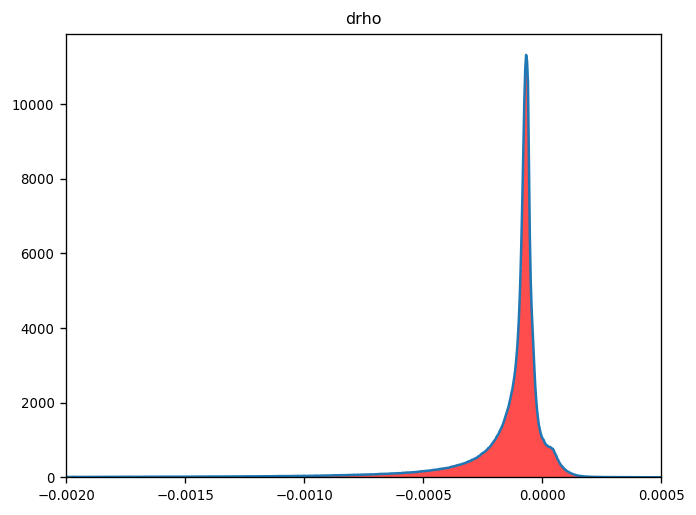

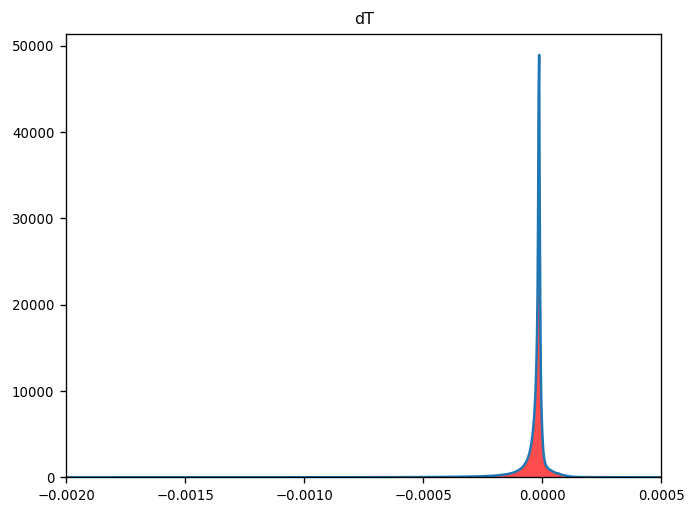

In [7]:
## diif density & temperature distributions

nbins = 100000
file = 'drho'
out_rho = get_dist(nbins, file)
file = 'dT'
out_temp = get_dist(nbins, file)


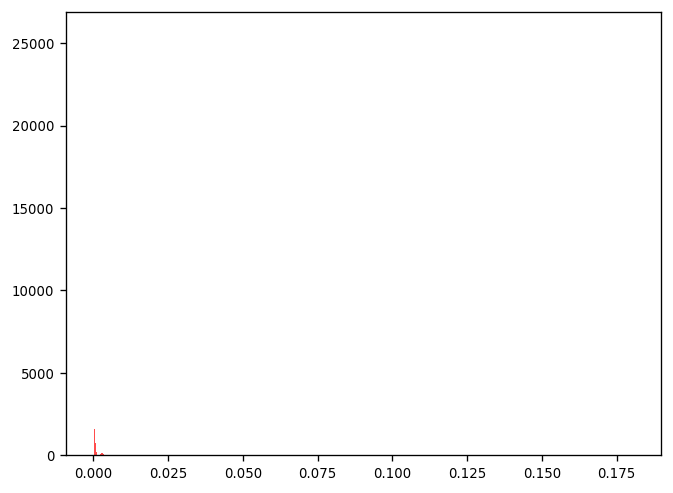

In [24]:
## dt distributions

nbins = 100000
dt1 = np.loadtxt(dataloc+'dtime1'+'.txt')
dt2 = np.loadtxt(dataloc+'dtime2'+'.txt')
dt3 = np.loadtxt(dataloc+'dtime3'+'.txt')
data = np.concatenate((dt1,dt2,dt3), axis = 0)  

# print(data.shape)

out = plt.hist(data,bins=nbins, density=True, color='r', alpha=0.7)


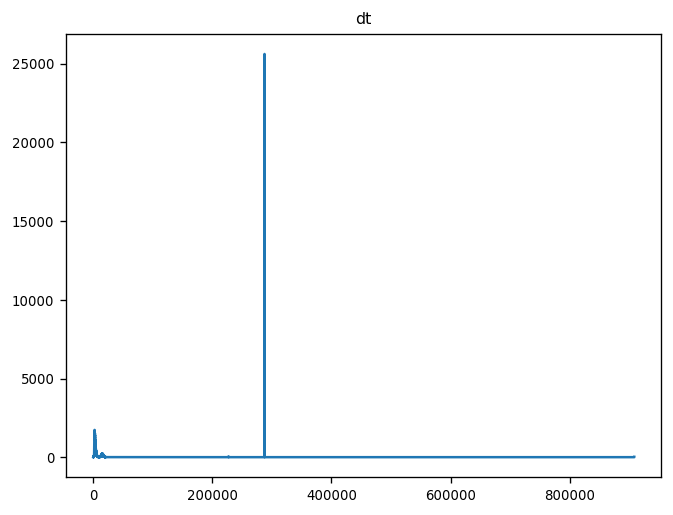

In [26]:
plt.title('dt')
plt.plot((out[1][:-1]*5022728.790082334),out[0])  ## because in PHANTOM code units ---> [sec]
# plt.xlim(-0.002, 0.075)
# plt.xscale('log')
plt.show()

In [27]:
np.save(samploc+'dtime', out[0])
np.save(samploc+'dtime_range', (out[1][:-1]*5022728.790082334)) 

In [11]:
np.save(samploc+'drho', out_rho[0]) 
np.save(samploc+'dT', out_temp[0]) 

In [16]:
np.save(samploc+'drho_range', out_rho[1][:-1]) 
np.save(samploc+'dT_range', out_temp[1][:-1]) 

### Data generation


In [8]:
# elke run eigen map, uniek, date ofzo
# checken op andere computer dat wanneer ge random seeds maakt, dat de random getallen effectief anders zijn
# nu enkel variaties van variabelen, begin met een gekozen input
# starten van de chemie waar ge mee eindigd --> paden in de fysiochemische ruimte
# eind abundantie terug meegeven, niet initialiseren

[4.50568935e+08 2.99854630e+03 9.15734543e-02 1.44416034e+00
 2.06977728e+04]
[15.7418077   0.03760958]


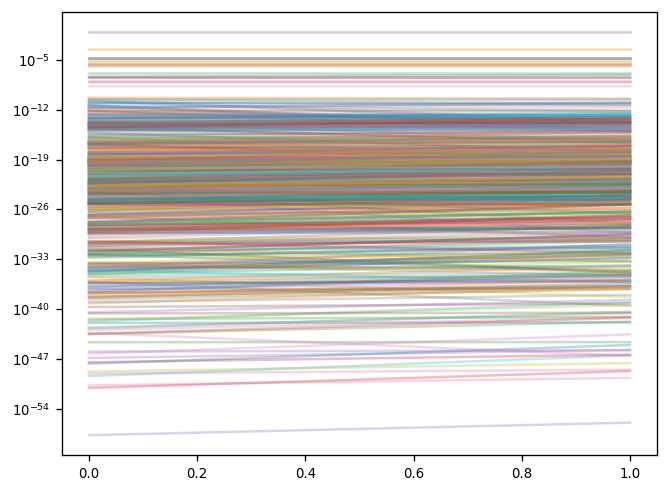

In [3]:

path = '/lhome/silkem/ChemTorch/ChemTorch/out/'
loc = '2023-08-08 23:48:50.881415'

input = np.load(path+loc+'/input.npy')
time = np.load(path+loc+'/tictoc.npy')

print(input)
print(time)
# print(np.load(path+'abundances.npy'))
abs = np.load(path+loc+'/abundances.npy')

for i in range(abs.shape[0]):
    plt.plot(abs[i], alpha = 0.3)

plt.yscale('log')

In [13]:
print(abs.T[-1])

[7.75066246e-08 1.67063151e-15 2.50086406e-17 1.26591693e-17
 1.35057431e-14 8.50000000e-02 1.50753519e-15 1.86525605e-19
 2.98939442e-24 9.10772284e-17 1.72323944e-14 4.60616137e-26
 1.66888917e-18 8.09664266e-16 1.25482964e-18 6.38578099e-20
 2.65090858e-14 1.52715776e-15 5.35932120e-12 1.41027099e-15
 4.12249917e-20 9.60093230e-15 1.21100315e-21 1.95610806e-19
 5.14348537e-17 1.16574846e-30 1.78308528e-14 4.60583548e-15
 1.75045738e-06 1.97296152e-18 4.29912512e-12 2.38075882e-21
 1.38688431e-14 2.04038952e-17 3.00336550e-08 5.21785529e-14
 1.27546690e-06 6.44914564e-20 2.59199193e-19 3.23883489e-13
 8.88204291e-23 8.49999999e-09 2.59628945e-23 9.08869381e-18
 0.00000000e+00 0.00000000e+00 4.04328844e-24 9.66444580e-20
 0.00000000e+00 0.00000000e+00 9.67025344e-12 2.67776357e-17
 1.49216300e-19 4.37178974e-14 1.34294648e-13 2.18999437e-05
 1.88728636e-15 3.43545667e-17 2.84609372e-20 2.04499897e-05
 7.00803959e-17 3.80381316e-11 6.23006361e-19 7.27676010e-16
 1.99999831e-05 5.260883

In [4]:
chemtype = 'C'

## set initial conditions
n, nconsv_tot, specs, nshield_i = rates.initialise_abs(chemtype, rate)     # nconsv_tot = TOTAL in fortran code


Δt =  get_dt()    ## sec
input = next_input(input)
n, name = solve_dg(input, Δt, rate, abs, nshield_i, nconsv_tot, '')


------------------------------------------------------------------------------
Name:
2023-08-09 01:38:19.244514

Input:
[density, temperature, delta, Av] dt:
[450515840.6574317, 2998.4180021402335, 0.7932376965902889, 4.696812237524296] 1942.1

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 1942.0 sec...
